# word2vec 속도 개선

3장에서 구현한 CBOW모델은 말뭉치에 포함된 어휘 수가 많아지면 계산량도 커진다.

이번 장의 목표는 word2vec의 속도 개선이다. 앞 장의 word2vec에 두 가지 개선을 추가한다.
1. Embredding
2. 네거티브 샘플링 (손실 함수)

## 4.1 word2vec 개선
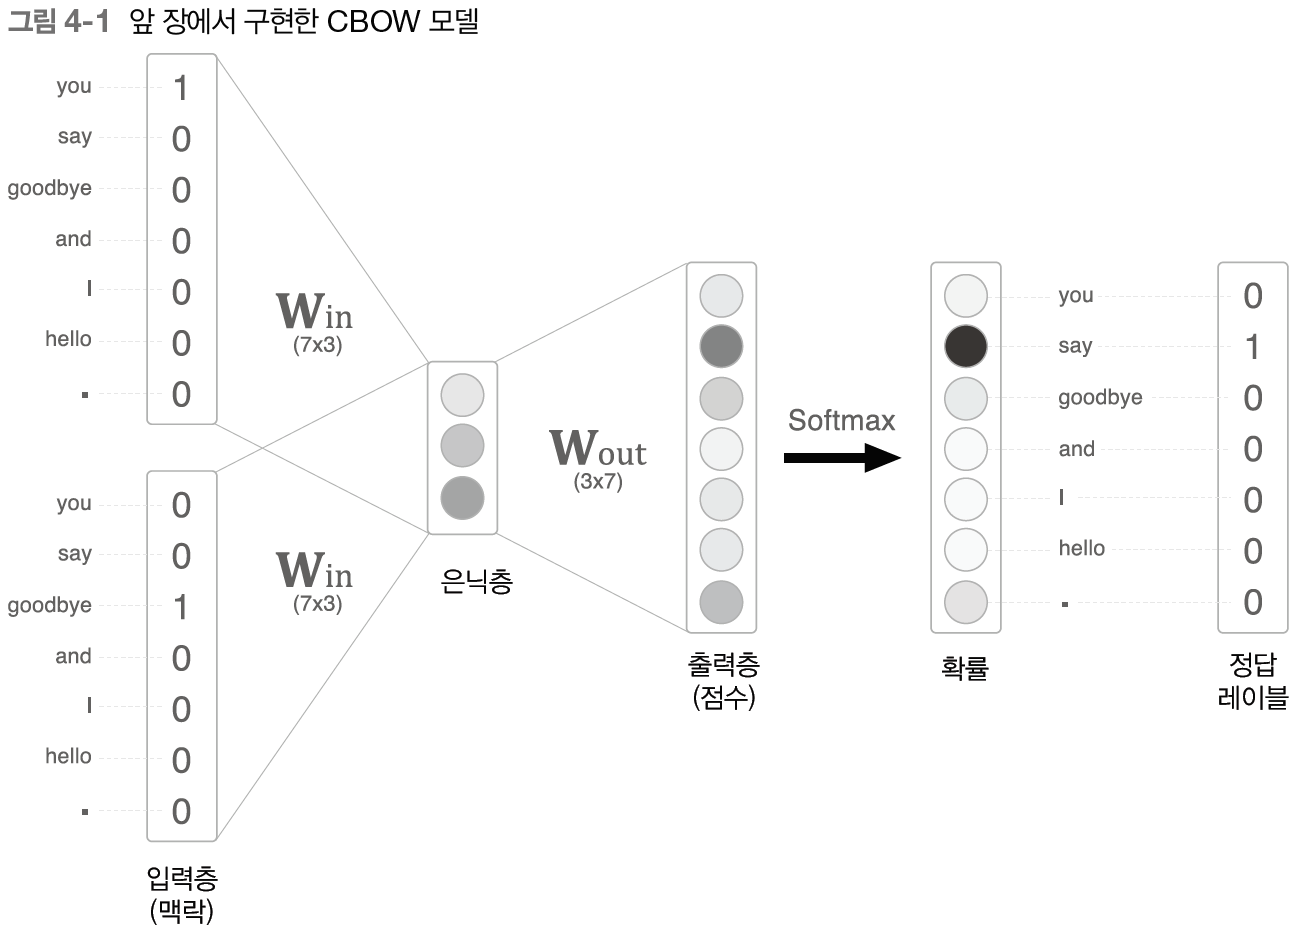

CBOW 모델은 단어 2개를 맥락으로 사용해, 하나의 단어를 추측한다.
가중치와의 행렬 곱으로 은닉층이 계산되고, 출력 측 가중치와의 행렬 곱으로 점수를 구한다.
이 점수에 소프트맥스 함수를 적용해 출현 확률을 얻고 손실을 구한다.

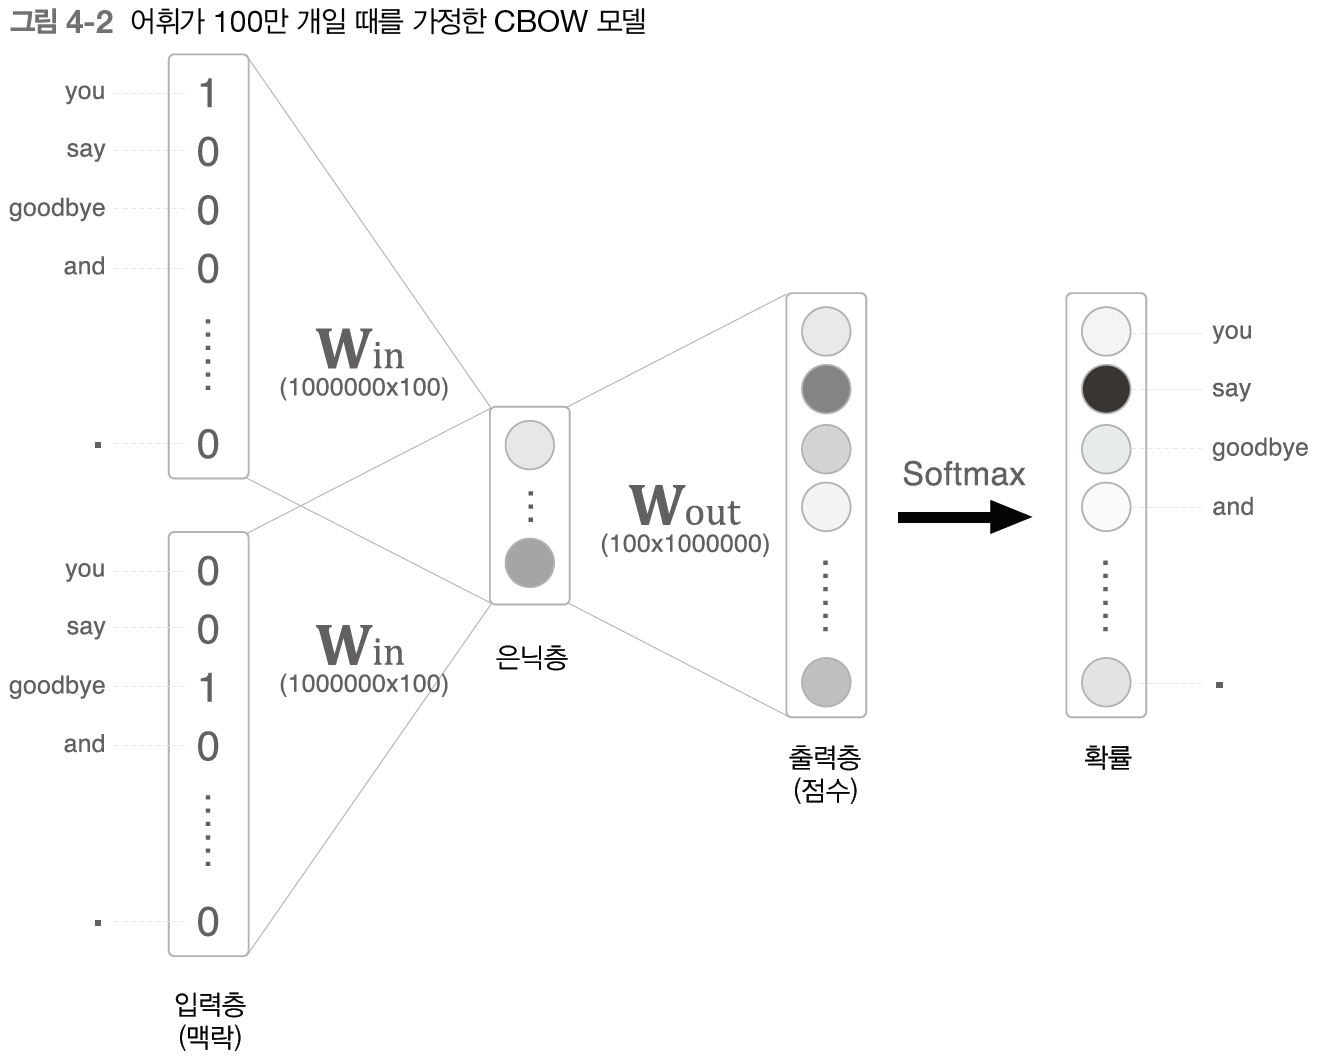

어휘가 100만개 일 때 생기는 병목현상
- 입력층의 원핫 표현과 가중치 행렬의 곱계산 (Embedding으로 해결)
- 은닉층과 가중치 행렬의 곱 및 Softmax 계층의 계산 (네거티브 샘플링으로 해결)

이 두 과정에서 계산해야할 원소 수가 100만 개의 벡터이기 때문에, 상당한 메모리를 차지한다.

### 4.1.1 Embedding 계층
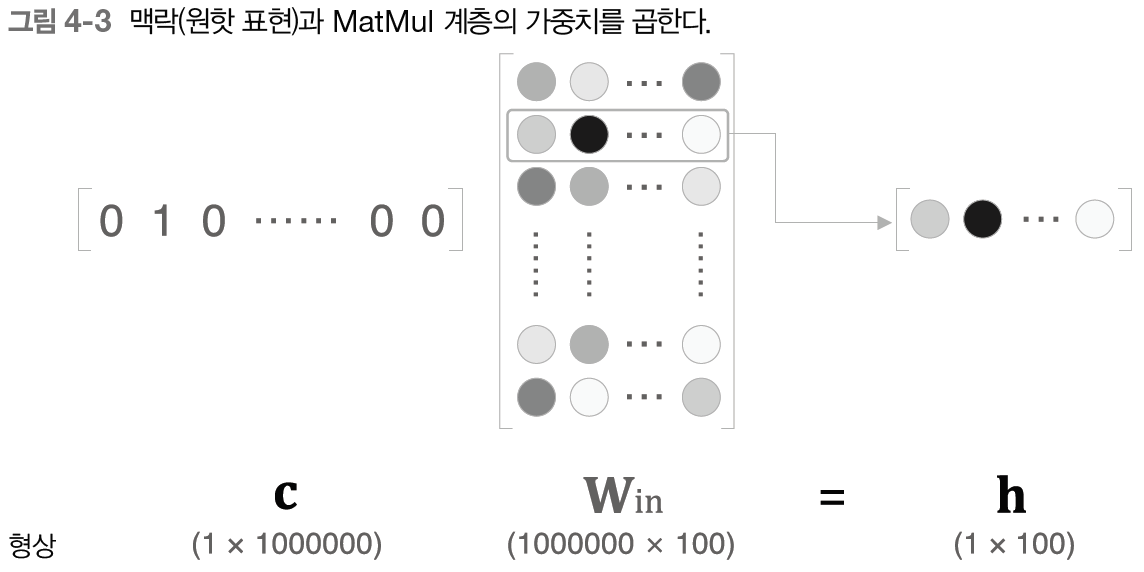

100만 개의 어휘를 담은 말뭉치는, 단어의 원학 표현도 100만 차원이 된다. 단지 행렬의 특정 행을 추출하는데 이렇게 많은 연산을 할 필요가 있을까?
그래서 가중치 매개변수로부터 '단어 ID에 해당하는 행(벡터)'을 추출하는 계층을 만들어보자
그 계층은 **Embedding** 계층이라고 한다. Embedding 계층에 단어의 분산표현을 저장한다.
> 자연어 처리 분야에서 단어의 밀집벡터 표현을 단어 임베딩 혹은 단어의 분산 표현 이라 한다. 참고로 통계 기반으로 얻은 단어 벡터는 영어로 distributional representation 이라 하고, 신경망을 사용한 추론 기반 기법으로 얻은 단어 벡터는 distributed representation 이라고 한다.

### 4.1.2 Embedding 계층 구현

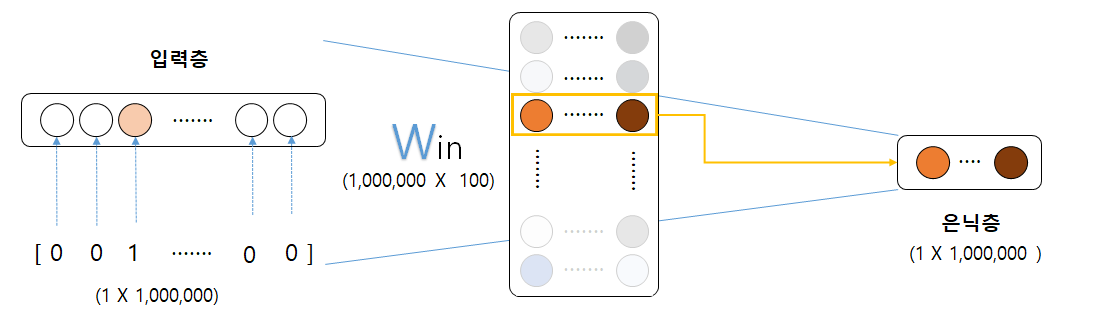
행렬에서 특정 행을 추출하기란 아주 쉽다. 예컨데 가중치 W가 2차원 넘파이 행렬일 때, 이 가중치로부터 특정 행을 추출하려면 그저 W[2]나 W[5]같은 원하는 행을 명시하면 끝이다. 가중치 W로부터 여러 행을 한꺼번에 추출하는 일도 간단하게 할 수 있다.

In [2]:
import numpy as np
W = np.arange(21).reshape(7, 3)
print(W)
print(W[2])
print(W[5])

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]
[6 7 8]
[15 16 17]


In [3]:
idx = np.array([1, 0, 3, 0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [4]:
# Embedding 계층의 구현

class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0 # dW 자체를 0으로 설정하는 게 아니라, dW의 형상을 유지한 채 그 원소들을 0으로 덮어쓰는 것.
        dW[self.idx] = dout # 실은 나쁜 예
        return None
    '''
    a = np.array([1, 2, 3])
    a[...] = 0
    >>> a
    array([0, 0, 0])
    '''

이 코드는 가중치 기울기 dW를 꺼낸 다음, dW[…] = 0 문장에서 dW의 원소를 0으로 덮어 쓴다. (dW자체를 0으로 설정하는게 아니라, dW의 형상을 유지한 채, 그 원소들을 0으로 덮어쓴다.) 그리고 앞 층에서 전해진 기울기 dout을 idx번째 행에 할당한다.

하지만 이러한 구현은 문제가 있다. idx가 중복될때 발생한다.
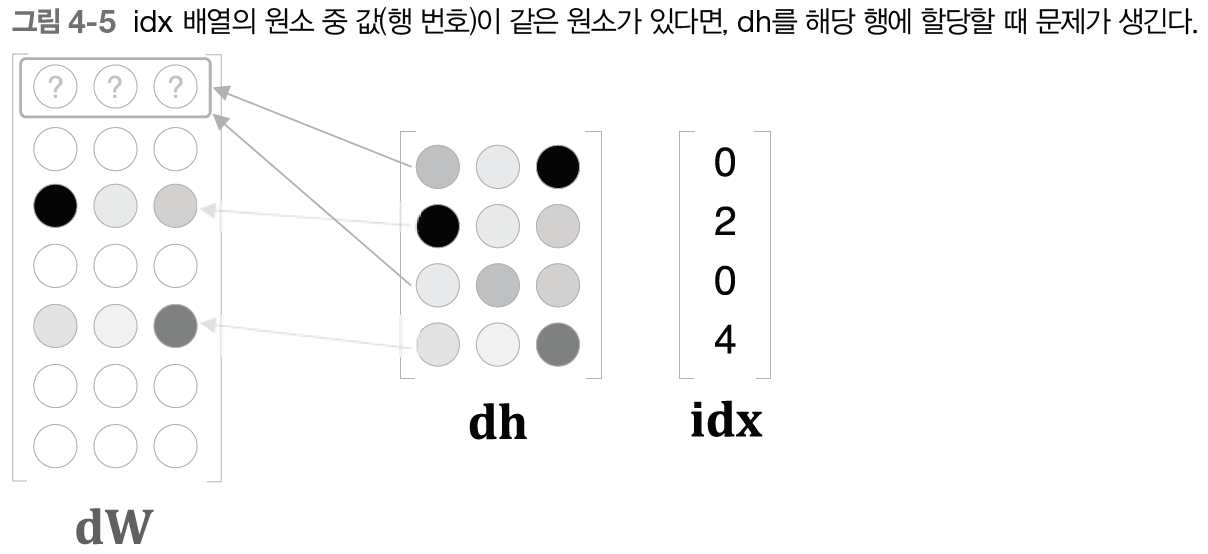
이렇게 되면 dW의 0번째 행에 2개의 값이 할당되어, 먼저 쓰여진 값을 덮어쓴다.

이 중복 문제를 해결하려면 ‘할당’이 아닌 ‘더하기’를 해야 한다. 즉, dh의 각 행의 값을 dW의 해당 행에 더해준다. 역전파를 올바르게 구현해 보자.

더하기를 하는 이유
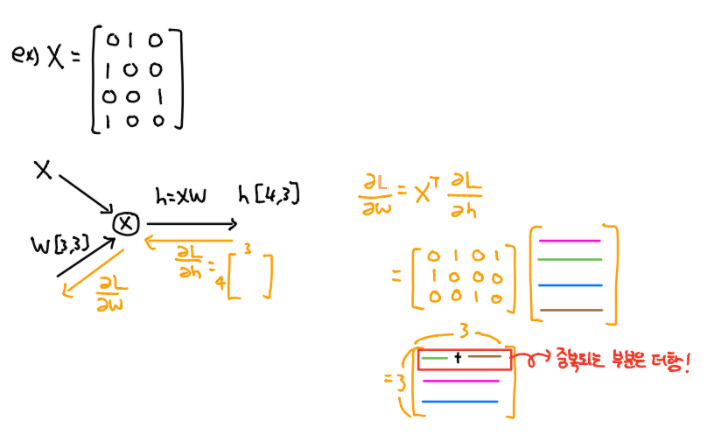

In [6]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0 # dW 자체를 0으로 설정하는 게 아니라, dW의 형상을 유지한 채 그 원소들을 0으로 덮어쓰는 것.
        
        #for i, word_id in enumerate(self.idx):
            #dw[word_id] += dout[i]
        # 혹은
        np.add.at(dW, self.idx. dout)
        
        return None

## 4.2 word2vec 개선 2
이제 두 번째 문제
**은닉층과 가중치 행렬 W(out)의 곱 및 Softmax 계층의 계산**
을 해결하기 위해 네거티브 샘플링이라는 기법을 사용해보자

Softmax 대신 네거티브 샘플링을 이용하면 어휘가 아무리 많아져도 계산량을 낮은 수준에서 일정하게 억제할 수 있다.

우선 문제점을 다시 한번 짚으면,

행렬곱은 어휘가 많아지면 복잡하고 시간이 오래 걸린다는 것을 알 수 있고,

softmax의 경우 softmax 식을 보았을 때 100만 개에 대해 모두 고려하여 확률 형태로 내기 때문에 이 또한 시간이 오래 걸린다는 것을 알 수 있다.

### 4.2.1 은닉층 이후 계산의 문제점

문제 1. 은닉층의 뉴런과 가중치 행렬의 곱
문제 2. Softmax 계층의 계산

첫 번째는 행렬 곱을 '가볍게' 만들어야한다.
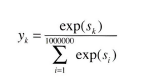
두 번째 역시 그림 처럼 계산량이 크므로 가볍게 만들어야 한다.

### 4.2.2 다중 분류에서 이진 분류로

핵심은 다중 분류(Multi-class classification)를 이중분류(binary classification)로 근사하는 것에 있다.
> 이진 분류는 "Yes/No"로 답하는 문제를 말한다.

이전에 질문과 답은 ' 'you'와 'goodbye'를 주면 타깃 단어가 무엇인가'를 찾았다면,
이진 분류로 근사하기 위해서는 ' 'you'와 'goodbye'를 줬을 때 타깃 단어는 'say'인가'를 질문하면 된다.
그러면 출력층에는 'say'일 확률에 대한 점수만 출력하면 되므로 뉴런을 하나만 준비하면 된다.
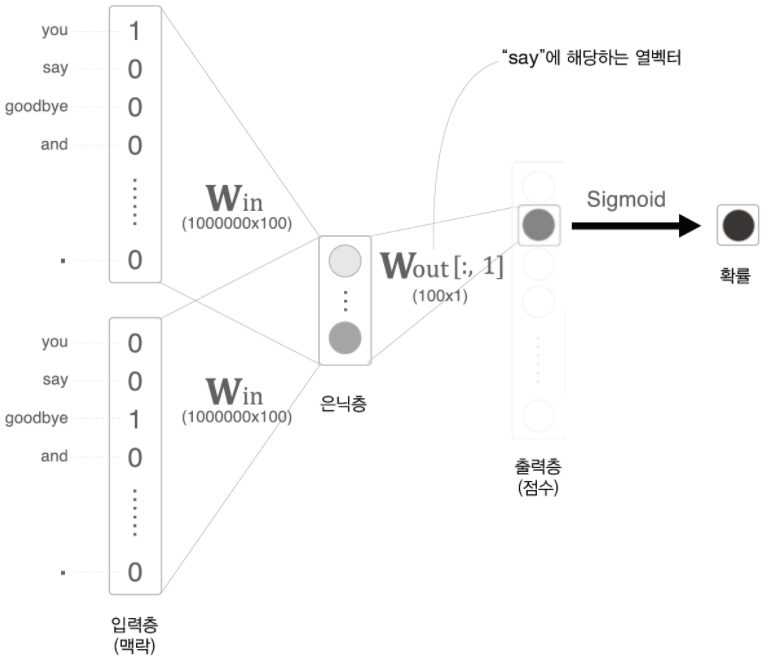

따라서 그림처럼 은닉층과 출력 층의 가중치 행렬의 내적은 'say'에 해당하는 열만 추출하여 앞의 은닉층 결과와 내적을 계산하면 된다.

'say'에 해당하는 열만 추출하는 과정 역시 embedding 계층이 사용되어서 추출한 후 내적이 수행될 것!

이진 분류 문제를 신경망으로 풀려면 점수에 시그모이드 함수를 적용해 확률로 변환하고, 손실 함수를 구할 때 Cross entropy를 사용한다.

(보통 다중 분류-softmax&cross-entropy, 이중분류-sigmoid&cross-entropy)
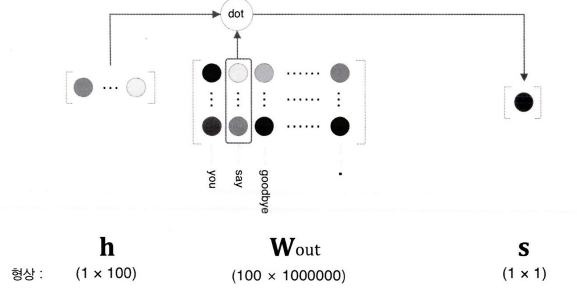

### 4.2.3 시그모이드 함수와 교차 엔트로피 오차
시그모이드는 이진분류에 사용되는 활성화 함수 값이다.
핵심은 시그모이드 함수의 출력(y)을 '확률'로 해석할 수 있다.
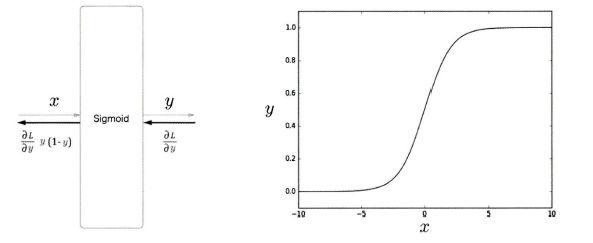
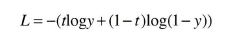
<center> 시그모이드를 사용한 '교차 엔트로피 오차' <center/>
오차가 의미하는 것은 정답 레이블인 t가 1이면 정답이 "Yes"이고, 0이면 No를 의미한다.
t가 1이면 -logy가 출력되고, 반대로 t가 0이면 -log(1-y)가 출력된다.

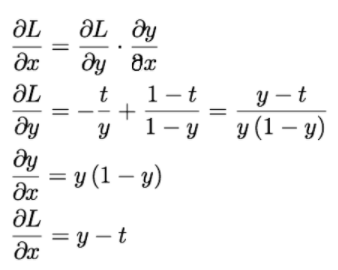
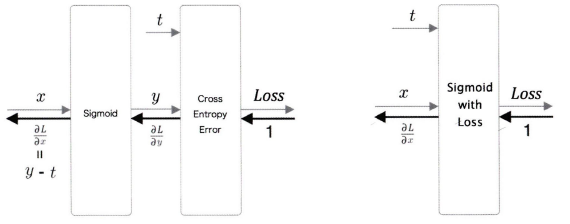

정답 레이블이 1이라면 y가 1에 가까워 질수록 오차가 줄어든다.
> '시그모이드 함수'와 '교차 엔트로피 오차'를 조합하여 역전파 값이 y-t라는 깔끔한 결과를 도출한다.
마찬가지로 '소프트맥스 함수'와 '교차 엔트로피 오차'의 조합, 또는 '항등 함수'와 '2 제곱 오차'의 조합에서도 역전파 시에는 y-t값이 전파 된다.

### 4.2.4 다중 분류에서 이진 분류로
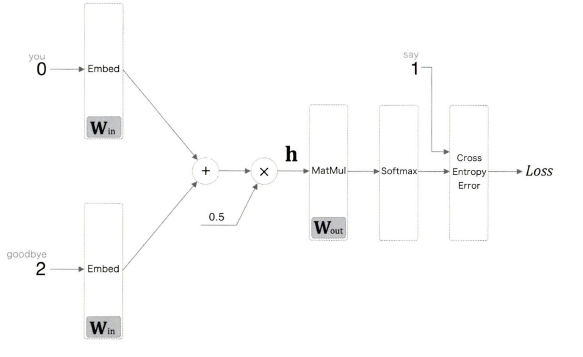 
<center> 다중 분류를 수행하는 CBOW 모델의 전체 그림 </center>

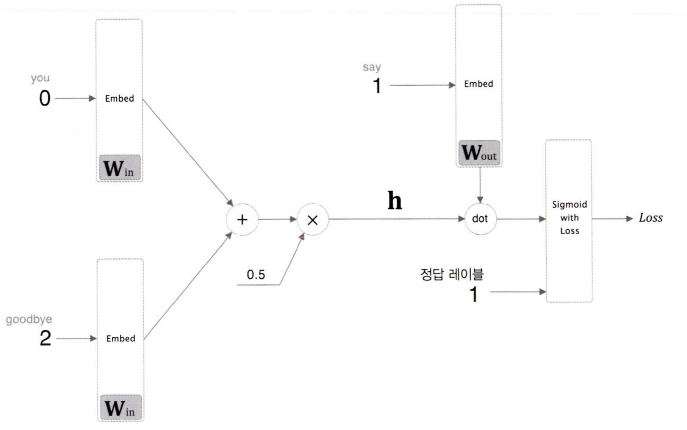
<center> 이진 분류를 수행하는 word2vec의 전체 그림 </center>

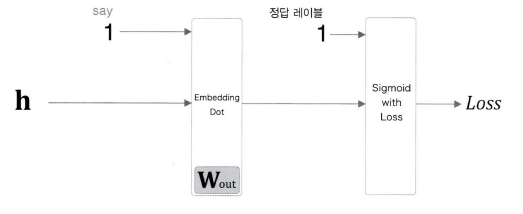

<center> 은닉층 이후 처리 (Embedding Dot 계층을 사용하여 Embedding 계층과 내적 계산을 한 번에 수행 </center>

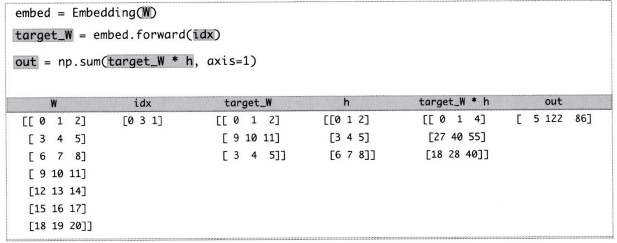

In [7]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
        
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)
        
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        
        dout = dout.reshape(dout.shape[0], 1)
        
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

### 4.2.5 네거티브 샘플링
‘다중 분류’에서 ‘이진 분류’로 변환할 수 있었다. 하지만 이것이 다가 아니다. 지금까지는 긍정적인 예(정답)에 대해서만 학습했기 때문이다. 다시 말해 부정적인 예(오답)을 입력하면 어떤 결과가 나올지 확실하지 않다.
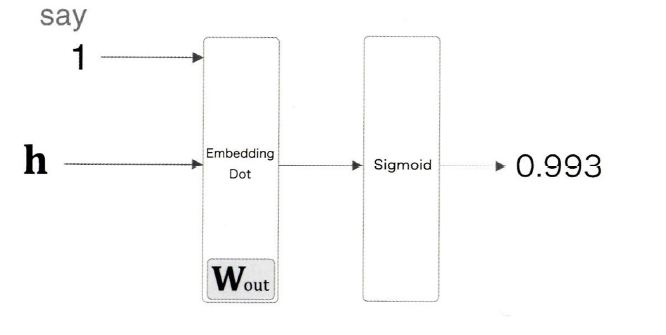

현재의 신경망에서는 긍정적 예인 “say”에 대해서만 학습하게 된다. 그러나 부정적인 예에 대해서는 아무런 지식도 획득하지 못했다. 긍정적 예(“say”)에 대해서는 Sigmoid 계층의 출력을 1에 가깝게 만들어야 하고, 부정적 예(“say” 이외의 단어)에 대해서는 Sigmoid 계층의 출력을 0에 가깝게 만들어야 한다.

이를 실현시키기 위해서, 모든 부정적 예를 대상으로 하여 이진 분류를 학습시킬 수 있지만,
이는 어휘 수가 늘어나면 감당할 수 없으므로,
부정적 예를 몇 개 선택한다.
즉, 적은 수의 부정적 예를 샘플링해 사용한다.
이것이 바로 **'네거티브 샘플링'** 기법입니다.

네거티브 샘플링 기법은 긍정적 예를 타깃으로 한 경우의 손실을 구하되,
그와 동시에 부정적 예를 몇 개 샘플링하여, 그 부정적 예에 대해서도 마찬가지로 손실을 구한다.
그리고 각각의(긍정적, 부정적) 데이터의 손실을 더한 값으로 최종 손실로 한다.
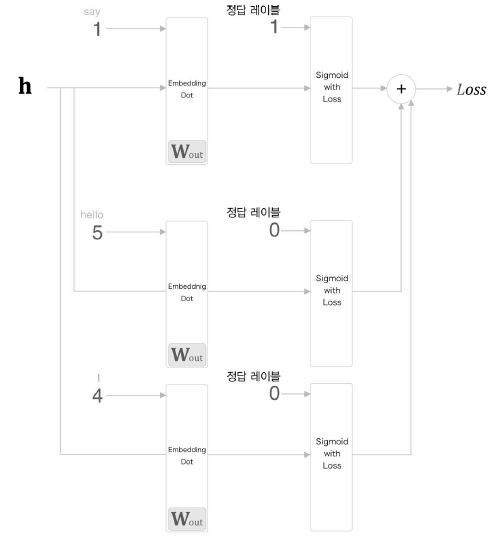

### 4.2.6 네거티브 샘플링의 샘플링 기법
앞서 부정적인 예를 모두 사용하면 비효율적이어서 일부만을 샘플링한다고 했는데,
부정적인 예를 어떻게 샘플링할까?
단순히 무작위로 샘플링(선별)하는 것보다, 말뭉치의 통계 데이터를 기초로 샘플링하는 방법을 사용한다.
말뭉치에서 자주 등장하는 단어를 많이 추출하고 드물게 등장하는 단어를 적게 추출한다.
> 결국 네거티브 샘플링은 정답에 해당되지 않는 단어들을 대표해서 몇 개 선별하는 것인데 희소 단어들보다는 자주 나온 단어들이 부정적 예를 대표해서 학습시키는 것이 좋을 것이다.

샘플링을 하는데 사용되는 핵심 함수는 **np.random.choice()** 함수이다

In [9]:
import numpy as np

words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
np.random.choice(words)

'goodbye'

In [12]:
# 5개만 무작위로 샘플링 (중복 있음)
np.random.choice(words, size=5)

array(['hello', 'goodbye', 'you', 'goodbye', 'hello'], dtype='<U7')

In [13]:
# 5개만 무작위로 샘플링 (중복 없음)
np.random.choice(words, size=5, replace=False)

array(['goodbye', 'say', 'hello', 'you', 'I'], dtype='<U7')

In [14]:
# 확률 분포에 따라 샘플링
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice(words, p=p)

'you'

그런데 여기서 확률분포에서 한 가지를 더 수정해준다.
바로 기존 기본 확률분포에 0.75를 제곱하는 것이다.
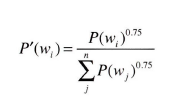
P(wi)는 i번째 단어의 확률을 뜻한다. 수정하는 이유는 **출현 확률이 낮은 단어를 '버리지 않기'위해서**이다.
0.75를 제곱함으로써, 원래 확률이 낮은 단어의 확률을 살짝 높일 수 있다. 
수정 전 확률인 0.01 (1%)가 0.0265 (약 2.65%)로 높아졌습니다. 0.75말고 다른 값으로 설정해도 된다.

In [17]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


이러한 처리를 UnigramSampler 라는 이름으로 제공한다.
> 유니그램이란 하나의 (연속된) 단어라는 뜻이다. 바이그램은 2개의 연속된 단어를, 트라이그램은 3개의 연속된 단어를 뜻한다. 따라서 UnigramSampler 클래스의 이름에는 한 단어를 대상으로 확률분포를 만든다는 의미가 녹여져 있다. 만약 이를 ‘바이그램’ 버전으로 만든다면 (‘you’, ‘say’), (‘you’, ‘goodbye’) … 같이 두 단어로 구성된 대상에 대한 확률분포를 만들게 된다.

In [19]:
import collections
GPU=False
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)  # 전체 합이 1이 되도록 확률 설정

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum() # 정답 부분의 확률을 0으로 만들어 버렸으니 남은 확률들의 합이 1이되도록 하기 위해서
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

매개 변수는 corpus, 제곱 수, 샘플링할 수
corpus를 기반으로 말뭉치 안의 단어들의 발생 확률을 구해 확률분포를 구하고
이를 제곱 수만큼 제곱을 시켜서 확률로 다시 표현 후, get_negative_sample로 정답 단어의 확률은 0으로 설정하고 np.random.choice()로 샘플링할 수만큼 샘플링을 해서 샘플링된 값을 결과로 넘긴다.

In [21]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negatvie_sample = sampler.get_negative_sample(target)
print(negatvie_sample)

[[2 4]
 [1 2]
 [2 3]]


[1, 3, 0]에 각각 부정적 예 2개 [2 4] [1 2] [2 3]임을 알 수 있다

### 4.2.7 네거티브 샘플링 구현

In [23]:
from common.layers import SigmoidWithLoss
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target) # 1+i는 [0]은 긍정적 예를 다루는 계층이므로
            loss += self.loss_layers[1 + i].forward(score, negative_label)
            
        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
        return dh